<a href="https://colab.research.google.com/github/tiarmdhnt/Titanic-Classification-Pipeline/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [11]:
spark = SparkSession \
    .builder \
    .appName("Classification Titanic Data") \
    .getOrCreate()

In [12]:
dataset_path = "/content/train.csv"

In [13]:
titanic_df = spark.read.csv(dataset_path,header = 'True',inferSchema='True')

In [14]:
passengers_count = titanic_df.count()

In [15]:
print(passengers_count)

891


In [16]:
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

# **Melakukan Proses ETL dan preprocessing dari data yang telah dimuat di HDFS**

In [17]:
#Membaca dataset menggunakan spark secara langsung dan masukkan ke suatu variabel
titanic_df = spark.read.csv(dataset_path,header = 'True',inferSchema='True')

In [18]:
#Melakukan penghitungan pada data csv

passengers_count = titanic_df.count()

print(passengers_count)

891


In [19]:
#Menampilkan 5 data teratas
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [20]:
#Menampilkan semua ringkasan data yang ada
titanic_df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [21]:
#Menampilkan skema dari dataset
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [22]:
#Memilih kolum untuk klasifikasi
titanic_df.select("Survived","Pclass","Embarked").show()

+--------+------+--------+
|Survived|Pclass|Embarked|
+--------+------+--------+
|       0|     3|       S|
|       1|     1|       C|
|       1|     3|       S|
|       1|     1|       S|
|       0|     3|       S|
|       0|     3|       Q|
|       0|     1|       S|
|       0|     3|       S|
|       1|     3|       S|
|       1|     2|       C|
|       1|     3|       S|
|       1|     1|       S|
|       0|     3|       S|
|       0|     3|       S|
|       0|     3|       S|
|       1|     2|       S|
|       0|     3|       Q|
|       1|     2|       S|
|       0|     3|       S|
|       1|     3|       C|
+--------+------+--------+
only showing top 20 rows



In [23]:
#Menampilkan total status survived
titanic_df.groupBy("Survived").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [24]:
#Menampilkan total status survived berdasarkan gender
titanic_df.groupBy("Sex","Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



In [25]:
#Menampilkan total status survived berdasarkan Pclass
titanic_df.groupBy("Pclass","Survived").count().show()

+------+--------+-----+
|Pclass|Survived|count|
+------+--------+-----+
|     1|       0|   80|
|     3|       1|  119|
|     1|       1|  136|
|     2|       1|   87|
|     2|       0|   97|
|     3|       0|  372|
+------+--------+-----+



In [26]:
#Mengecek data yang kosong
def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

null_columns_count_list = null_value_count(titanic_df)

import pandas as pd

# Load the CSV file
df = pd.read_csv(dataset_path)

# Display rows with at least one null value
print(df[df.isnull().any(axis=1)])


     PassengerId  Survived  Pclass                                      Name  \
0              1         0       3                   Braund, Mr. Owen Harris   
2              3         1       3                    Heikkinen, Miss. Laina   
4              5         0       3                  Allen, Mr. William Henry   
5              6         0       3                          Moran, Mr. James   
7              8         0       3            Palsson, Master. Gosta Leonard   
..           ...       ...     ...                                       ...   
884          885         0       3                    Sutehall, Mr. Henry Jr   
885          886         0       3      Rice, Mrs. William (Margaret Norton)   
886          887         0       2                     Montvila, Rev. Juozas   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch        

In [27]:
#Menampilkan rata-rata usia penumpang
mean_age = titanic_df.select(mean('Age')).collect()[0][0]
print(mean_age)

29.69911764705882


In [28]:
#Mengambil data dari kolum nama untuk initial
titanic_df = titanic_df.withColumn("Initial", regexp_extract(col("Name"), "([A-Za-z]+)\\.", 1))
titanic_df.show()


+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|   Miss|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|    Mrs|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|     Mr|
|          6|   

In [29]:
#Mengambil data dari inisial tanpa perulangan
titanic_df.select("Initial").distinct().show()

+--------+
| Initial|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



In [30]:
#Mengubah inisial yang salah
titanic_df = titanic_df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
               ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

titanic_df.select("Initial").distinct().show()

+-------+
|Initial|
+-------+
|   Miss|
|  Other|
| Master|
|     Mr|
|    Mrs|
+-------+



In [31]:
#Cek rata-rata usia penumpang berdasarkan initial/gender
titanic_df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [32]:
#Melakukan manipulasi data untuk baris kosong
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Miss") & (titanic_df["Age"].isNull()), 22).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Other") & (titanic_df["Age"].isNull()), 46).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Master") & (titanic_df["Age"].isNull()), 5).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Mr") & (titanic_df["Age"].isNull()), 33).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Mrs") & (titanic_df["Age"].isNull()), 36).otherwise(titanic_df["Age"]))

titanic_df.filter(titanic_df.Age==46).select("Initial").show()

+-------+
|Initial|
+-------+
|     Mr|
|     Mr|
|     Mr|
+-------+



In [33]:
titanic_df.select("Age").show()

+----+
| Age|
+----+
|22.0|
|38.0|
|26.0|
|35.0|
|35.0|
|33.0|
|54.0|
| 2.0|
|27.0|
|14.0|
| 4.0|
|58.0|
|20.0|
|39.0|
|14.0|
|55.0|
| 2.0|
|33.0|
|31.0|
|36.0|
+----+
only showing top 20 rows



In [34]:
titanic_df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [35]:
titanic_df = titanic_df.na.fill({"Embarked" : 'S'})

In [36]:
#Melakukan penghapusan kolum pada cabin
titanic_df = titanic_df.drop("Cabin")
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Initial: string (nullable = true)



In [37]:
#Melakukan penggabungan data
titanic_df = titanic_df.withColumn("Family_Size",col('SibSp')+col('Parch'))

In [38]:
#Meghitung data berdasarkna family size
titanic_df.groupBy("Family_Size").count().show()

+-----------+-----+
|Family_Size|count|
+-----------+-----+
|          1|  161|
|          6|   12|
|          3|   29|
|          5|   22|
|          4|   15|
|          7|    6|
|         10|    7|
|          2|  102|
|          0|  537|
+-----------+-----+



In [39]:
titanic_df = titanic_df.withColumn('Alone',lit(0))
titanic_df = titanic_df.withColumn("Alone",when(titanic_df["Family_Size"] == 0, 1).otherwise(titanic_df["Alone"]))
titanic_df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked',
 'Initial',
 'Family_Size',
 'Alone']

In [40]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(titanic_df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
titanic_df = pipeline.fit(titanic_df).transform(titanic_df)

titanic_df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|          1|    0|      0.0|           0.0|          0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|          1|    0|      1.0|           1.0|          2.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|          0|  

In [41]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Initial: string (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)



In [42]:
#Menghapus kolom yang tidak digunakan
titanic_df = titanic_df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")
titanic_df.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


In [43]:
#Memasukkan ke dalam vektor
feature = VectorAssembler(inputCols=titanic_df.columns[1:],outputCol="features")
feature_vector= feature.transform(titanic_df)

feature_vector.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|            features|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|(10,[0,1,2,4,5],[...|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|[1.0,38.0,1.0,0.0...|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|[3.0,26.0,0.0,0.0...|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|[1.0,35.0,1.0,0.0...|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|(10,[0,1,4,6],[3....|
|       0|     3|33.0|    0|    

In [44]:
#Split Data
(trainingData, testData) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

# **Membuat Model**

In [45]:
#Menggunakan Logistic Regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Survived", featuresCol="features")
#Training algo
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)
lr_prediction.select("prediction", "Survived", "features").show()
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [46]:
lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of LogisticRegression is = %g"% (lr_accuracy))
print("Test Error of LogisticRegression = %g " % (1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.771277
Test Error of LogisticRegression = 0.228723 


In [47]:
#Menggunakan Desicion Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
dt_model = dt.fit(trainingData)
dt_prediction = dt_model.transform(testData)
dt_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [48]:
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

Accuracy of DecisionTreeClassifier is = 0.819149
Test Error of DecisionTreeClassifier = 0.180851 


In [49]:
#Menggunakan Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
rf = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)
rf_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [50]:
rf_accuracy = evaluator.evaluate(rf_prediction)
print("Accuracy of RandomForestClassifier is = %g"% (rf_accuracy))
print("Test Error of RandomForestClassifier  = %g " % (1.0 - rf_accuracy))

Accuracy of RandomForestClassifier is = 0.819149
Test Error of RandomForestClassifier  = 0.180851 


In [51]:
#Menggunakan Gradient-Boosted tree Classifier
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Survived", featuresCol="features",maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_prediction = gbt_model.transform(testData)
gbt_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [52]:
gbt_accuracy = evaluator.evaluate(gbt_prediction)
print("Accuracy of Gradient-boosted tree classifie is = %g"% (gbt_accuracy))
print("Test Error of Gradient-boosted tree classifie %g"% (1.0 - gbt_accuracy))

Accuracy of Gradient-boosted tree classifie is = 0.803191
Test Error of Gradient-boosted tree classifie 0.196809


# **Visualisasi Data**

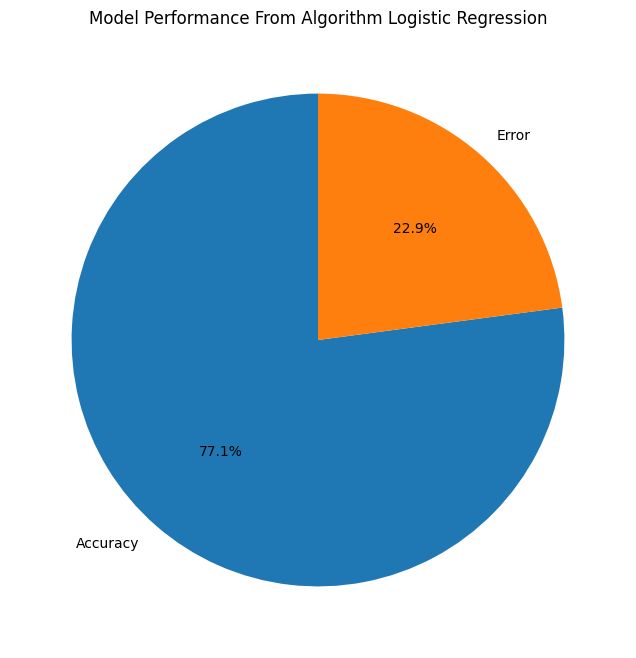

In [59]:
#Algoritma Logistic Regression

import pandas as pd
import matplotlib.pyplot as plt

# Data in the form of a dictionary
error = 1-lr_accuracy
accuracy = lr_accuracy

# Convert to percentage strings
accuracy = f"{lr_accuracy * 100:.1f}%"  # Format as a percentage with one decimal
error = f"{error * 100:.1f}%"  # Format as a percentage with one decimal

# Data in the form of a dictionary
data = {'Metric': ['Accuracy', 'Error'],
        'Value': [float(accuracy.strip('%')), float(error.strip('%'))]}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 8))
plt.pie(df['Value'], labels=df['Metric'], autopct='%1.1f%%', startangle=90)
plt.title('Model Performance From Algorithm Logistic Regression')
plt.show()


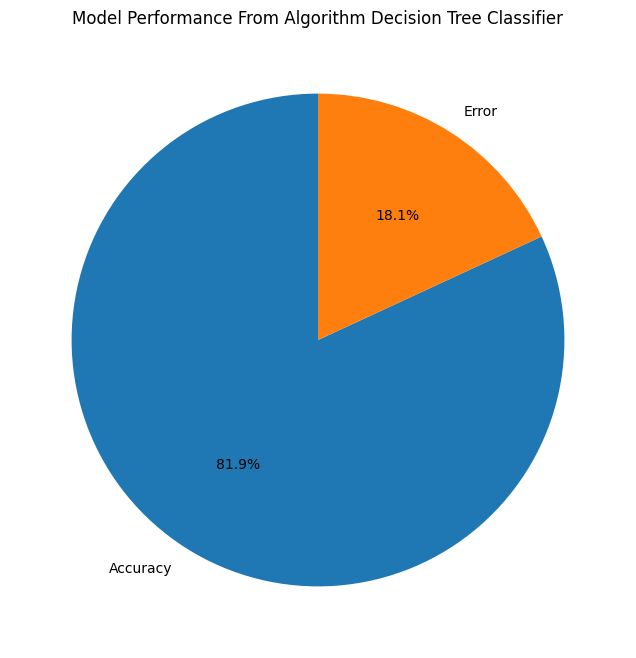

In [60]:
#Decision Tree Classifier

import pandas as pd
import matplotlib.pyplot as plt

# Data in the form of a dictionary
error = 1-dt_accuracy
accuracy = dt_accuracy

# Convert to percentage strings
accuracy = f"{accuracy * 100:.1f}%"  # Format as a percentage with one decimal
error = f"{error * 100:.1f}%"  # Format as a percentage with one decimal

# Data in the form of a dictionary
data = {'Metric': ['Accuracy', 'Error'],
        'Value': [float(accuracy.strip('%')), float(error.strip('%'))]}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 8))
plt.pie(df['Value'], labels=df['Metric'], autopct='%1.1f%%', startangle=90)
plt.title('Model Performance From Algorithm Decision Tree Classifier')
plt.show()


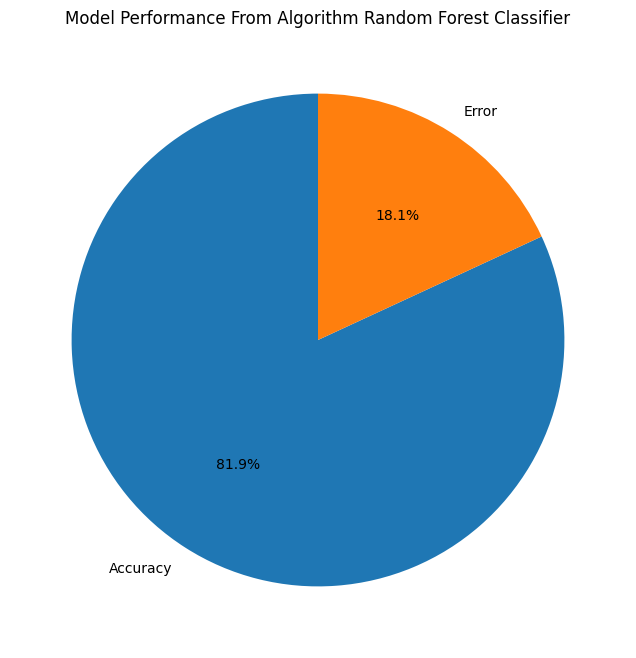

In [61]:
#Random Forest Classifier

import pandas as pd
import matplotlib.pyplot as plt

# Data in the form of a dictionary
error = 1-rf_accuracy
accuracy = rf_accuracy

# Convert to percentage strings
accuracy = f"{accuracy * 100:.1f}%"  # Format as a percentage with one decimal
error = f"{error * 100:.1f}%"  # Format as a percentage with one decimal

# Data in the form of a dictionary
data = {'Metric': ['Accuracy', 'Error'],
        'Value': [float(accuracy.strip('%')), float(error.strip('%'))]}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 8))
plt.pie(df['Value'], labels=df['Metric'], autopct='%1.1f%%', startangle=90)
plt.title('Model Performance From Algorithm Random Forest Classifier')
plt.show()


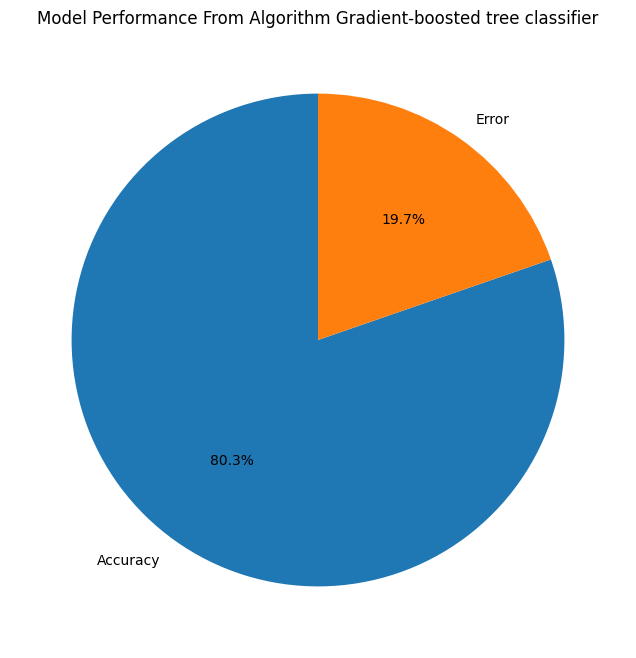

In [62]:
#Gradient-Boosted Classifier

import pandas as pd
import matplotlib.pyplot as plt

# Data in the form of a dictionary
error = 1-gbt_accuracy
accuracy = gbt_accuracy

# Convert to percentage strings
accuracy = f"{accuracy * 100:.1f}%"  # Format as a percentage with one decimal
error = f"{error * 100:.1f}%"  # Format as a percentage with one decimal

# Data in the form of a dictionary
data = {'Metric': ['Accuracy', 'Error'],
        'Value': [float(accuracy.strip('%')), float(error.strip('%'))]}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 8))
plt.pie(df['Value'], labels=df['Metric'], autopct='%1.1f%%', startangle=90)
plt.title('Model Performance From Algorithm Gradient-boosted tree classifier')
plt.show()


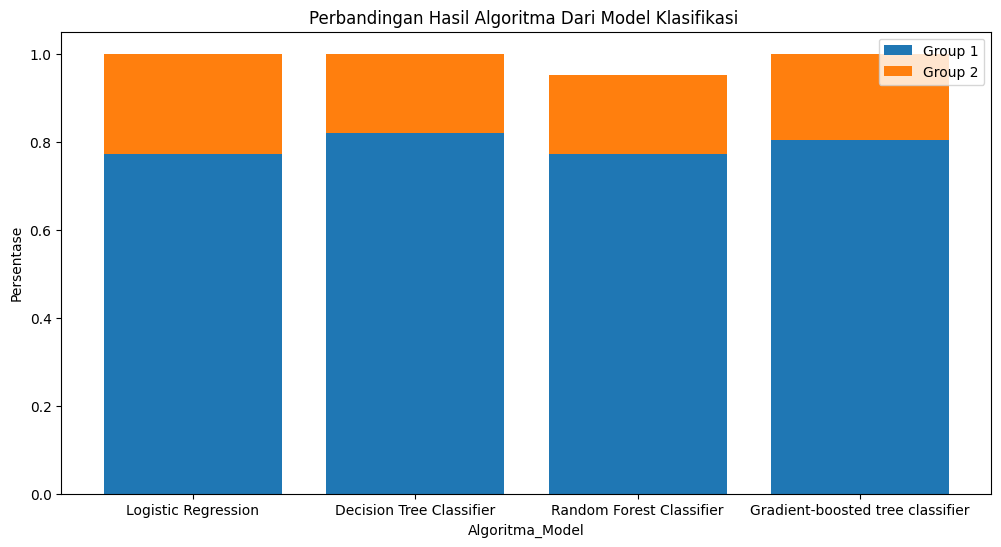

In [63]:
import matplotlib.pyplot as plt
import numpy as np

error_rf = 1-rf_accuracy
error_df = 1-dt_accuracy
error_lr = 1-lr_accuracy
error_gbt = 1-gbt_accuracy
# Sample data
Algoritma_Model = ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'Gradient-boosted tree classifier']
values1 = [lr_accuracy, dt_accuracy, lr_accuracy, gbt_accuracy]
values2 = [error_lr, error_df, error_rf, error_gbt]

x = np.arange(len(Algoritma_Model))  # the label locations

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(Algoritma_Model, values1, label='Group 1')
ax.bar(Algoritma_Model, values2, bottom=values1, label='Group 2')

ax.set_xlabel('Algoritma_Model')
ax.set_ylabel('Persentase')
ax.set_title('Perbandingan Hasil Algoritma Dari Model Klasifikasi ')
ax.legend()

plt.show()


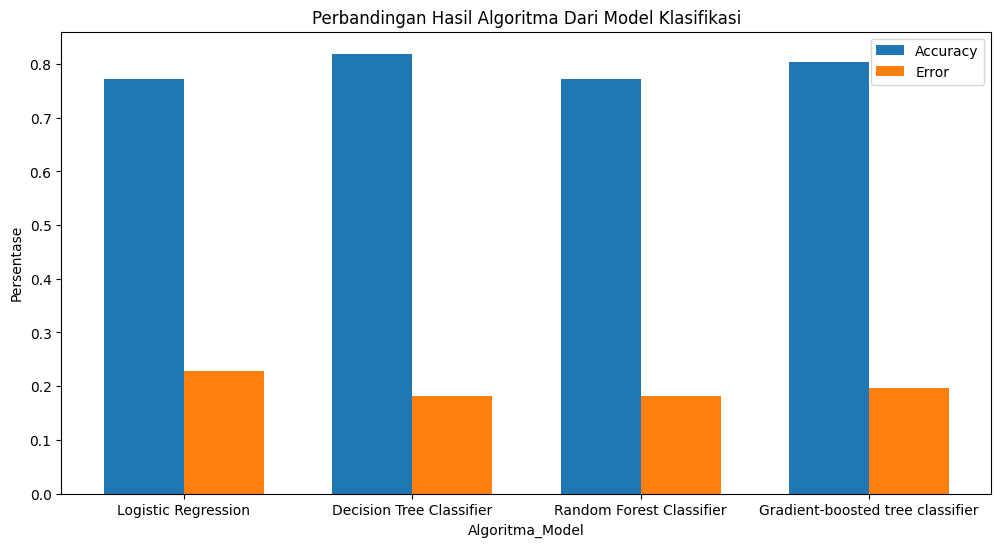

In [64]:
import matplotlib.pyplot as plt
import numpy as np

error_rf = 1-rf_accuracy
error_df = 1-dt_accuracy
error_lr = 1-lr_accuracy
error_gbt = 1-gbt_accuracy

# Sample data
Algoritma_Model = ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'Gradient-boosted tree classifier']
values1 = [lr_accuracy, dt_accuracy, lr_accuracy, gbt_accuracy]
values2 = [error_lr, error_df, error_rf, error_gbt]
x = np.arange(len(Algoritma_Model))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, values1, width, label='Accuracy')
rects2 = ax.bar(x + width/2, values2, width, label='Error')

ax.set_xlabel('Algoritma_Model')
ax.set_ylabel('Persentase')
ax.set_title('Perbandingan Hasil Algoritma Dari Model Klasifikasi')
ax.set_xticks(x)
ax.set_xticklabels(Algoritma_Model)
ax.legend()

plt.show()